In [64]:
from transformers import CLIPTokenizer, CLIPTextModel
from helperFunctions import VectorQuantizeImage, VecQVAE, FrameDataset
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import numpy as np
from einops import rearrange
import urllib
import io
from PIL import Image, ImageSequence
import pandas as pd

(np.float64(-0.5), np.float64(6043.5), np.float64(4028.5), np.float64(-0.5))

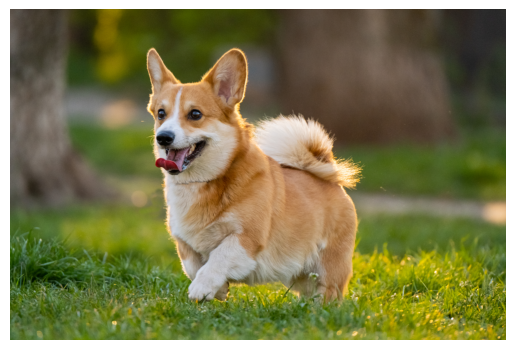

In [65]:
img = Image.open("imageVisualization/testImage.png")
npArray = np.array(img)
plt.imshow(img)
plt.axis('off')

In [66]:
tranform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [67]:
print(npArray.shape)
tensorFrames = tranform(img)
print(tensorFrames.shape)
tensorFrames = tensorFrames/255.0
tensorFrames.shape

(4029, 6044, 3)
torch.Size([3, 128, 128])


torch.Size([3, 128, 128])

In [68]:
codeBookdim = 256
embedDim = 128
hiddenDim = 256
inChannels = 3

device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
modelA = VecQVAE(inChannels = inChannels, hiddenDim = hiddenDim, codeBookdim = codeBookdim, embedDim = embedDim).to(device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.7663674e-12..1.5089381].


torch.Size([1, 128, 128, 3])


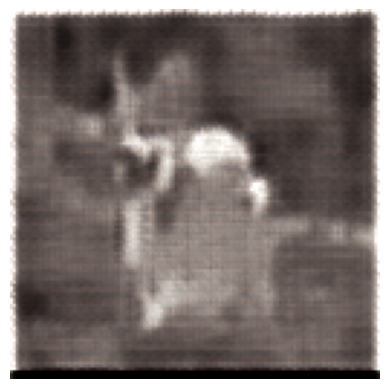

In [69]:
modelValA = torch.load("models/VQVAE-GIF-thread-1.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)
with torch.inference_mode():
    encodedImage = modelA.encodeImage(tensorFrames.unsqueeze(0), )
    decodedImage = modelA.decodeImage(encodedImage)

decodedImage = rearrange(decodedImage, 'b c h w -> b h w c')
npImage = (decodedImage * 255.0).squeeze().squeeze().detach().numpy()
print(decodedImage.shape)
plt.imshow(npImage)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [6.6744726e-12..1.42575].


torch.Size([1, 128, 128, 3])


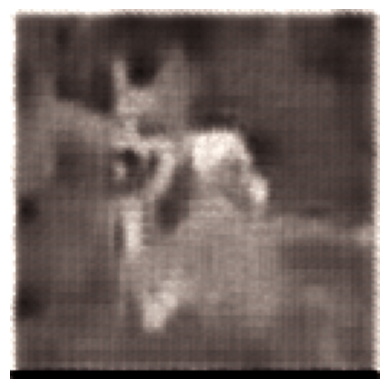

In [70]:
modelValA = torch.load("models/VQVAE-GIF-thread-2.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)
with torch.inference_mode():
    encodedImage = modelA.encodeImage(tensorFrames.unsqueeze(0), )
    decodedImage = modelA.decodeImage(encodedImage)

decodedImage = rearrange(decodedImage, 'b c h w -> b h w c')
npImage = (decodedImage * 255.0).squeeze().squeeze().detach().numpy()
print(decodedImage.shape)
plt.imshow(npImage)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.972431e-15..1.4314617].


torch.Size([1, 128, 128, 3])


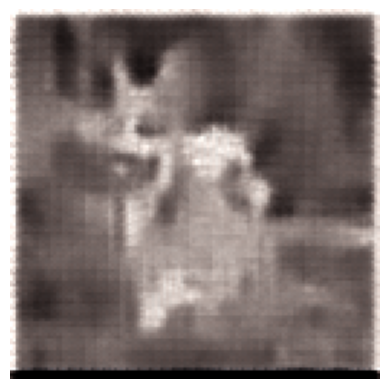

In [72]:
modelValA = torch.load("models/VQVAE-GIF-thread-3-1.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)
with torch.inference_mode():
    encodedImage = modelA.encodeImage(tensorFrames.unsqueeze(0), )
    decodedImage = modelA.decodeImage(encodedImage)

decodedImage = rearrange(decodedImage, 'b c h w -> b h w c')
npImage = (decodedImage * 255.0).squeeze().squeeze().detach().numpy()
print(decodedImage.shape)
plt.imshow(npImage)
plt.axis('off')
plt.show()

In [51]:
tensorFrames.dtype

torch.float32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.052965e-12..1.4413447].


torch.Size([1, 128, 128, 3])


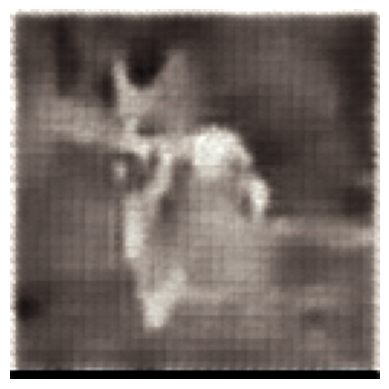

In [26]:
modelValA = torch.load("models/VQVAE-GIF-thread-3.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)
with torch.inference_mode():
    encodedImage = modelA.encodeImage(tensorFrames.unsqueeze(0), )
    decodedImage = modelA.decodeImage(encodedImage)

decodedImage = rearrange(decodedImage, 'b c h w -> b h w c')
npImage = (decodedImage * 255.0).squeeze().squeeze().detach().numpy()
print(decodedImage.shape)
plt.imshow(npImage)
plt.axis('off')
plt.show()

In [39]:
p = []
a = torch.tensor(np.array([1,2,3,4,5]))
p.append(a)
a = torch.tensor(np.array([1,2,3,4,5]))
p.append(a)

p = torch.stack(p, dim=0)
p.shape

torch.Size([2, 5])

In [46]:
fallback = torch.zeros((256, 256, 3))
encodedImage = modelA.encodeImage(tensorFrames.unsqueeze(0))
print(encodedImage.shape)

last_frame = encodedImage[-1:]               
last_frame = last_frame.repeat(20, 1, 1, 1)
print(encodedImage.shape, last_frame.shape)
images = torch.concat([encodedImage, last_frame], dim=0)
images.shape

torch.Size([1, 128, 32, 32])
torch.Size([1, 128, 32, 32]) torch.Size([20, 128, 32, 32])


torch.Size([21, 128, 32, 32])

In [63]:
class FrameDataset(Dataset):
    def __init__(self, data, vqvaeModel, totalSequence = 40, transform = None):
        super().__init__()
        self.data = data
        self.transform = transform
        self.totalSequence = totalSequence
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        self.vqvaeModel = vqvaeModel
        

    def __len__(self):
        return len(self.data)
    
    def npArray(self, index):
        try:
            row = self.data.iloc[index]
            url = row['url']
            resp = urllib.request.urlopen(url)
            image_data = resp.read()
            img = Image.open(io.BytesIO(image_data))
    
            frames = []
            for frame in ImageSequence.Iterator(img):
                frame_rgb = frame.convert("RGB")
                frames.append(np.array(frame_rgb))
    
            return frames
    
        except Exception as e:
            print(f"Error processing index {index}: {e}")
            fallback = torch.zeros((256, 256, 3), dtype=torch.uint8)
            return [fallback.numpy()]
    
    def __getitem__(self, index):
        # print(index)
        gif = self.npArray(index)
        caption = self.data.iloc[index]['caption']
        totalframes = len(gif)#self.data.iloc[index]['frames']
        
        if totalframes < self.totalSequence:
            gif += [gif[-1]] * (self.totalSequence - totalframes)

        tensorFrames = torch.stack([
            self.transform(Image.fromarray(frame)) for frame in gif
        ])

        tensorFrames = tensorFrames/255.0
        inputs = self.tokenizer(caption, return_tensors="pt")
        with torch.no_grad():
            encodedFrames = self.vqvaeModel.encodeImage(tensorFrames)
            text_embedding = self.text_encoder(**inputs).last_hidden_state.mean(dim=1)

        return tensorFrames, caption, encodedFrames, text_embedding
    

dataset = pd.read_csv("/Users/ishananand/Desktop/Text-To-Video-Generation/data/modified_tgif.csv")
dataset = dataset[(dataset['frames'] <= 40) & (dataset['frames'] > 15)].copy().reset_index(drop=True)
dataset = dataset[:10000] 

dataset.shape

tranform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

fdata = FrameDataset(dataset, modelA, transform=tranform)

frames, caption, encodedFrames, textEmbeddings = fdata.__getitem__(1)
print(frames.shape, caption, encodedFrames.shape, textEmbeddings.shape)

torch.Size([40, 3, 128, 128]) a man dressed in red is dancing. torch.Size([40, 128, 32, 32]) torch.Size([1, 512])


In [ ]:
class FrameDataset(Dataset):
    def __init__(self, data, totalSequence = 40, transform = None):
        super().__init__()
        self.data = data
        self.transform = transform
        self.totalSequence = totalSequence

    def __len__(self):
        return len(self.data)
    
    def npArray(self, index):
        try:
            row = self.data.iloc[index]
            totalframes = self.data.iloc[index]['frames']
            url = row['url']
            resp = urllib.request.urlopen(url)
            image_data = resp.read()
            img = Image.open(io.BytesIO(image_data))
    
            frames = []
            for frame in ImageSequence.Iterator(img):
                frame_rgb = frame.convert("RGB")
                frames.append(np.array(frame_rgb))
    
            return frames
    
        except Exception as e:
            print(f"Error processing index {index}: {e}")
            fallback = torch.zeros((256, 256, 3), dtype=torch.uint8)
            return [fallback.numpy()]
    
    def __getitem__(self, index):
        # print(index)
        gif = self.npArray(index)
        caption = self.data.iloc[index]['caption']
        totalframes = len(gif)#self.data.iloc[index]['frames']
        
        if totalframes < self.totalSequence:
            gif += [gif[-1]] * (self.totalSequence - totalframes)

        tensorFrames = torch.stack([
            self.transform(Image.fromarray(frame)) for frame in gif
        ])

        tensorFrames = tensorFrames/255.0

        return tensorFrames, caption
    

tranform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

fdata = FrameDataset(dataset, transform=tranform)

X, Y = fdata.__getitem__(1)
print(X.shape, Y)

In [61]:
rad = torch.randn(10, 40, 3, 128, 128)
out = modelA.encodeImage(rad)
out.shape

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [10, 40, 3, 128, 128]

In [32]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

text = "a cat jumping on a bed"
inputs = tokenizer(text, return_tensors="pt")
with torch.no_grad():
    text_embedding = text_encoder(**inputs).last_hidden_state.mean(dim=1)

text_embedding.shape

torch.Size([1, 512])